In [1]:
import numpy as np
import pandas as pd
import os
import pyarrow.parquet as pq
import s3fs
from pyspark.sql import SparkSession, functions as f
from kedro.extras.datasets.pandas import HDFDataSet
from matplotlib import pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
from xgboost import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from scipy import stats
import statsmodels.formula.api as smf
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.options.mode.chained_assignment = None

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/matplotlib/__init__.py:169: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jan_

### Equations used

- AR: $X_t = \sum_{i=1}^p \phi_i X_{t-i} + \epsilon_t$

- MA: $X_t = \mu + \epsilon_t + \sum_{i=1}^p \phi_i * \epsilon_{t-1}$ 

- ARMA: $X_t = c + \epsilon_t + \sum_{i=1}^p \phi_i * X_{t-1} + \sum_{i=1}^q \rho_i * \epsilon_{t-1}$ 

- Differencing first order: $y_{t+1}^{D_1} = y_{t+1} - y_t$

### Functions for model evaluation

In [2]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def mae(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

### Co2 data: Decomposition and de-trending

We decompose the time-series using statsmodel into:
- Trend
- Seasonality
- Residual/Noise

We also show different ways to remove the trend from a time-series.

In [3]:
df = sm.datasets.co2.load_pandas()
df = df.data

df= df.resample('M').mean().ffill()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/internals/blocks.py:1199: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: http

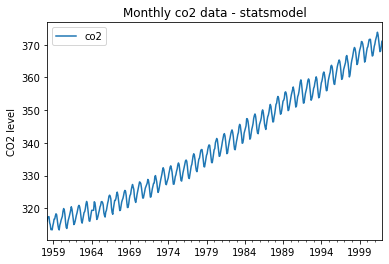

In [4]:
ax = df.plot()
ax.set_ylabel('CO2 level')
plt.title('Monthly co2 data - statsmodel')
plt.show()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


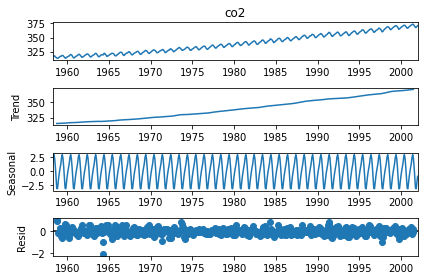

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal = seasonal_decompose(df.co2, model='additive')
seasonal.plot()
plt.show()

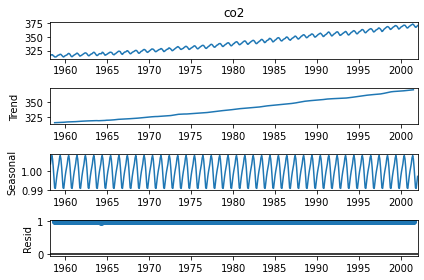

In [6]:
seasonal = seasonal_decompose(df.co2, model='multiplicative')
seasonal.plot()
plt.show()

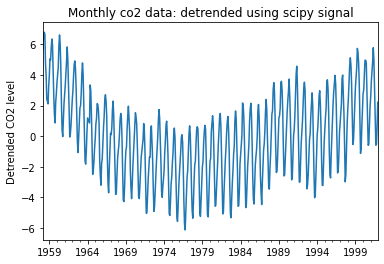

In [7]:
from scipy import signal

df['detrended_co2_v1'] = signal.detrend(df['co2'].values)

ax = df.detrended_co2_v1.plot()
ax.set_ylabel('Detrended CO2 level')
plt.title('Monthly co2 data: detrended using scipy signal')
plt.show()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/compat/_optional.py:99: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(version) < minimum_version:
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

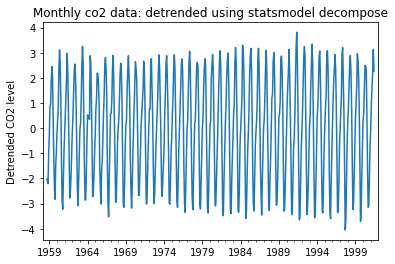

In [8]:
result_add = seasonal_decompose(df.co2, model='additive')
df['detrended_co2_v2'] = df['co2'].values - result_add.trend
#df['deseason_co2_v2'] = df['co2'].values - result_add.seasonal

ax = df.detrended_co2_v2.plot()
ax.set_ylabel('Detrended CO2 level')
plt.title('Monthly co2 data: detrended using statsmodel decompose')
plt.show()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


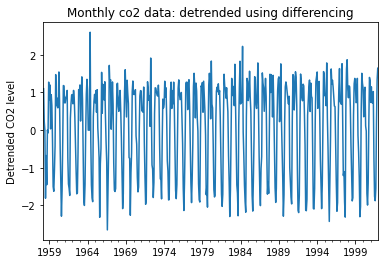

In [9]:
# y_t+1_diff = y_t+1 - yt

df['co2_diff'] = df.co2.diff(1)

ax = df.co2_diff.plot()
ax.set_ylabel('Detrended CO2 level')
plt.title('Monthly co2 data: detrended using differencing')
plt.show()

### Autocorrelation plots

Autocorrelation denotes the correlation of a time-series with itself over time. We need some autocorrelation to have meaningful memory from the past in order to make forecasts about the future. But we don't want some very strong/perfect auto-correlation, which is based on long-term trend (in most cases). Especially if we want to use covariates to explain short to mid term movements due to changes in the covariates, we might want to remove remove trend/seasonality, which results in lower autocorrelation (normally).

We show two types of autocorrelation:
- Autocorrelation
- Partial autocorrelation

The partial autocorrelation controls for previous correlations, thus really isolating the individual correlation from one time point to the other. Normally you have some kind of aggregated correlation over time, which includes information from time points beyond the last point. 

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


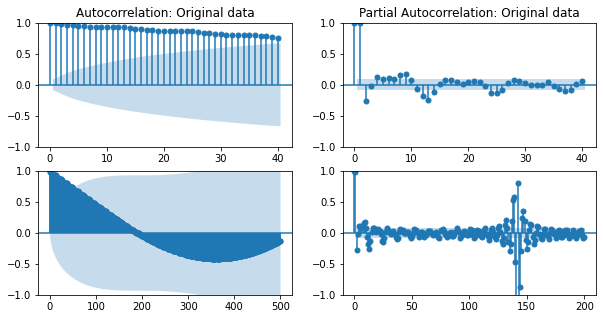

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(2,2,figsize=(10,5))
plot_acf(df.co2, lags=40, ax=ax[0][0])
ax[0][0].title.set_text('Autocorrelation: Original data')
plot_pacf(df.co2, lags=40, ax=ax[0][1])
ax[0][1].title.set_text('Partial Autocorrelation: Original data')
plot_acf(df.co2, lags=500, ax=ax[1][0])
ax[1][0].title.set_text('')
plot_pacf(df.co2, lags=200, ax=ax[1][1])
ax[1][1].title.set_text('')
plt.show()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


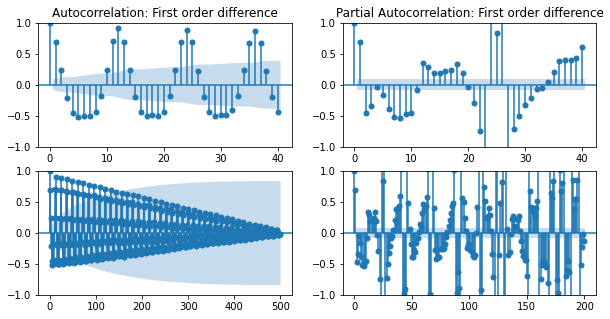

In [11]:
fig, ax = plt.subplots(2,2,figsize=(10,5))
plot_acf(df.co2.diff().dropna(), lags=40, ax=ax[0][0])
ax[0][0].title.set_text('Autocorrelation: First order difference')
plot_pacf(df.co2.diff().dropna(), lags=40, ax=ax[0][1])
ax[0][1].title.set_text('Partial Autocorrelation: First order difference')
plot_acf(df.co2.diff().dropna(), lags=500, ax=ax[1][0])
ax[1][0].title.set_text('')
plot_pacf(df.co2.diff().dropna(), lags=200, ax=ax[1][1])
ax[1][1].title.set_text('')
plt.show()

### Stationarity Test

Stationarity is important in classical time-series approaches like ARIMA (and also often in more modern methods like supervised machine learning and neural networks). 

A stationary time-series has stable:
- mean
- variance
- autocorrelation

This assures that the information we learned from the past helps us to make good forecasts. In machine learning approaches you could add time-based information like day/week/month/year to account for some trend and seasonality, but you might also try to make a time-series stationary to improve model performance. 

We can apply the Augmented Dickey-Fuller unit root test using statsmodel to check for stationarity:
- test the Null that the time-series is stationary (p <= .05 --> we reject hypothesis of non-stationarity)

To make a time-series stationary, a common way is to apply the first order differencing.

In [12]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.co2, regression='c')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.284810
p-value: 0.998945
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [13]:
result = adfuller(df.co2.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.923865
p-value: 0.000031
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


#### Modelling an AR/MA/ARIMA Process

Here we apply SARIMAX from statsmodels to show AR/MA and ARIMA models.
The order has three parameters for the ARIMA model:
- p = number of lags to include for the autoregressive part (AR)
- i = order of differencing used
- q = number of errors to include from the moving average part (MA)

The same we have for the seasonal_order:
- P = number of lags to include for the autoregressive part for the season (AR)
- I = order of differencing used for the seasonal part
- Q = number of errors to include from the moving average part for the season (MA) 

We also show ho to use scikit-learn TimeSeriesSplit to apply time-series cross-validation.

In [14]:
# Run MA Model

mod = sm.tsa.statespace.SARIMAX(endog=df.co2.values,
                                #trend='t',
                                mle_regression=True,
                                order =(5,1,3),
                                seasonal_order=(1,1,1,12)
                               )
res = mod.fit(disp=False) # disp --> surpresses the calculation details
print(res.summary())

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  526
Model:             SARIMAX(5, 1, 3)x(1, 1, [1], 12)   Log Likelihood                -151.935
Date:                              Tue, 05 Jul 2022   AIC                            325.869
Time:                                      08:24:00   BIC                            372.512
Sample:                                           0   HQIC                           344.152
                                              - 526                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4797      2.188     -0.219      0.826      -4.768       3.809
ar.L2          0.35

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


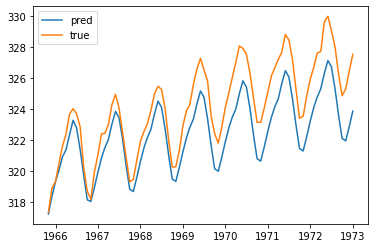

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


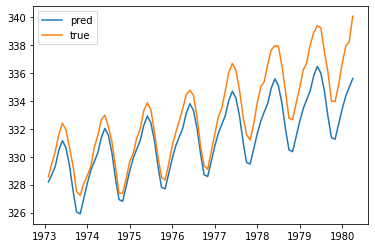

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


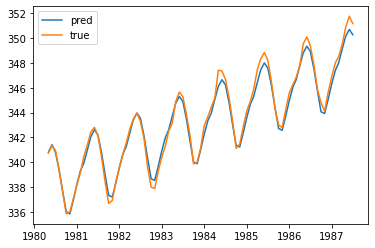

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


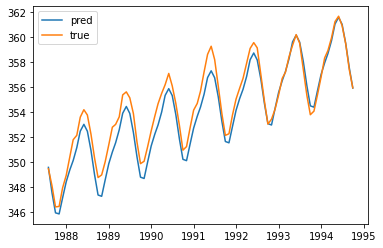

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


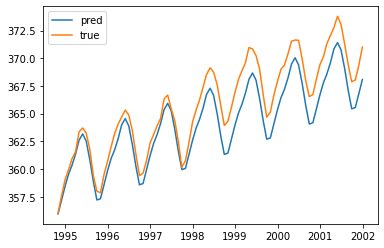

[0.005404324190237902, 0.004841626591712421, 0.0011130084642449114, 0.002431061929754045, 0.00455453405736597]
[1.75789142262081, 1.6195675920931802, 0.38361858284856787, 0.8603813370852246, 1.6731393238775099]


In [15]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(max_train_size=None, n_splits=5)
mape_ls = []
mae_ls = []

for train_indx, test_indx in tscv.split(df.co2.values):
    y_train, y_test = df.co2.values[train_indx], df.co2.values[test_indx]
    
    mod = sm.tsa.statespace.SARIMAX(endog=y_train,
                                #exog=X_train,
                                #trend='t',
                                mle_regression=True,
                                #order=stepwise_model.get_params()['order'],
                                order =(5,1,3),
                                #simple_differencing=True,
                                seasonal_order=(1,1,1,12)
                               )
    res = mod.fit(disp=False)
    
    pred_temp = res.forecast(steps=len(test_indx))
    
    # plot true vs prediction:
    plt.plot(df.index.values[test_indx],
         pred_temp,
        label='pred')

    plt.plot(df.index.values[test_indx],
             df.co2.values[test_indx],
            label='true')
    plt.legend()
    plt.show()
    mape_ls.append(mape(df.co2.values[test_indx], pred_temp))
    mae_ls.append(mae(df.co2.values[test_indx], pred_temp))
    #print(mape(df.co2.values[test_indx], pred_temp))
print(mape_ls)
print(mae_ls)

### Auto-Arima for SARIMAX

One could in theory tune the p,i,q and P,I,Q parameters applying some loop and finding the best parameters. But there is auto_arima, which does exactly this. One can either run all possible combinations or use stepwise option, which tries to find the best set of values without running all combinations. 

One can also either find the best model based in the AIC on the training data or decide to decide based on some out-of-bag testing. 

In [16]:
df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv')

df_asl['visits'] = df_asl.num_cph_visit * df_asl.num_hcp_asl_mccp
df_exog = df_asl.groupby('yyyymm')[['xrlt_sales','visits']].sum()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/compat/_optional.py:99: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if distutils.version.LooseVersion(version) < minimum_version:
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depreca

In [17]:
# Fitting OLS with month and year
df_exog = sm.add_constant(df_exog)

model = sm.OLS(df_exog.xrlt_sales,
            df_exog[['const', 'visits']])
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             xrlt_sales   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     12.46
Date:                Tue, 05 Jul 2022   Prob (F-statistic):            0.00188
Time:                        08:24:17   Log-Likelihood:                -354.65
No. Observations:                  24   AIC:                             713.3
Df Residuals:                      22   BIC:                             715.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.838e+06   2.04e+05     48.191      0.000    9.42e+06    1.03e+07
visits       163.5337     46.330      3.530      0.002      67.452     259.616
==============================================================================
Omnibus:                        4.750   Durbin-Watson:                   2.567
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                3.065
Skew:                           0.473   Prob(JB):                        0.216
Kurtosis:                       4.473   Cond. No.                     6.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
df_exog.corr()

,const,xrlt_sales,visits
const,NaN,NaN,NaN
xrlt_sales,NaN,1.000000,0.601304
visits,NaN,0.601304,1.000000


In [19]:
from pmdarima.arima import auto_arima

test_length = 12

#y_train = df.co2[:-test_length]
#y_test = df.co2[-test_length:]

y_train = df_exog.xrlt_sales[:-test_length].values.reshape(-1, 1) 
y_test = df_exog.xrlt_sales[-test_length:].values.reshape(-1, 1) 

exog_train = df_exog.visits[:-test_length].values.reshape(-1, 1) 
exog_test = df_exog.visits[-test_length:].values.reshape(-1, 1) 

stepwise_model = auto_arima(y_train, 
                            exogenous=exog_train,
                            start_p=1, start_q=1,
                            max_p=3, max_q=3, 
                            m=12, # frequency of series --> monthly
                            start_P=0, 
                            #seasonal=False,
                            #d=None, 
                            D=0, 
                            trace=1,
                            #method='ncg',
                            #with_intercept=False,
                            maxiter=500,
                            #error_action='ignore', 
                            error_action='trace',
                            #information_criterion='oob', # option to apply out of bag testing
                            #out_of_sample_size=2, # sample size for oob testing
                            suppress_warnings=True, 
                            stepwise=True) # if false it tests all possible combinations
print(stepwise_model.aic())

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pmdarima/compat/pmdarima.py:22: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  DeprecationWarning


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=403.500, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=399.130, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=407.248, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=436.290, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=397.146, Time=0.04 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=399.145, Time=0.08 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=399.889, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=405.255, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=397.351, Time=0.04 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12] intercept
Total fit time: 1.379 seconds
397.146108430109


In [20]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   12
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -194.573
Date:                Tue, 05 Jul 2022   AIC                            397.146
Time:                        08:24:18   BIC                            399.086
Sample:                             0   HQIC                           396.428
                                 - 12                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.257e+06    3.2e+06      0.392      0.695   -5.02e+06    7.53e+06
x1           453.9657   5211.330      0.087      0.931   -9760.054    1.07e+04
ar.L1          0.8418      0.469      1.796      0.073      -0.077       1.761
sigma2      1.586e+13      0.335   4.73e+13      0.000    1.59e+13    1.59e+13
===================================================================================
Ljung-Box (L1) (Q):                   6.37   Jarque-Bera (JB):                 0.08
Prob(Q):                              0.01   Prob(JB):                         0.96
Heteroskedasticity (H):               0.18   Skew:                             0.09
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.95e+29. Standard errors may be unstable.
"""

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pmdarima/compat/pmdarima.py:22: DeprecationWarning: The `exogenous` key-word has been deprecated. Please use `X` instead. This will raise an error in future versions. For more information, see: http://alkaline-ml.com/pmdarima/develop/rfc/372-exog-to-x.html
  DeprecationWarning


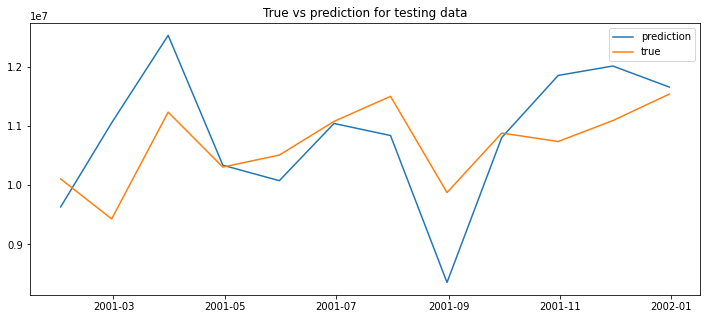

In [21]:
prediction, confint = stepwise_model.predict(n_periods=test_length, 
                  exogenous=exog_test,
                  return_conf_int=True)

plt.figure(figsize=(12,5))
plt.title('True vs prediction for testing data')
plt.plot(df.index[-test_length:],
        prediction, label='prediction')
#plt.plot(df.index[-test_length:],
#        confint[:,0], label='lower bound', ls='--', lw=.8, alpha=.5, color='red')
#plt.plot(df.index[-test_length:],
#        confint[:,1], label='upper bound', ls='--', lw=.8, alpha=.5, color='orange')
plt.plot(df.index[-test_length:],
         y_test, label='true')
plt.legend()
plt.show()

### Var and Varmax Model

The Var and Varmax model can be used in a multivariate setting. The Varmax allows us to use additional covariates in the model. These algorithms are used most often when there is some expected relationship between the different time-series. So the information of the other time-series can be used to make predictions of another time-series.

The the Varmax case we will first train a moel using our target time-series and one covariate time-series. Then we will scale this covariate time-series to zero to estimate a counterfactual: what would have been the outcome had there been no actions. Then we can compare the outcome with th original covariate values and the situation with x=0, which can be seen as a treatment effect of x

In [22]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX

In [23]:
# load italy data

df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv')

df_asl = df_asl[(df_asl.asl!='FABRIANO')
               #&(df_asl.region!='VALLE D\'AOSTA')
               # &(df_asl.region!='MARCHE')
               ].copy()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [24]:
df = df_asl.pivot_table(index='yyyymm',
                    columns='macro',
                    values='xrlt_sales')

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


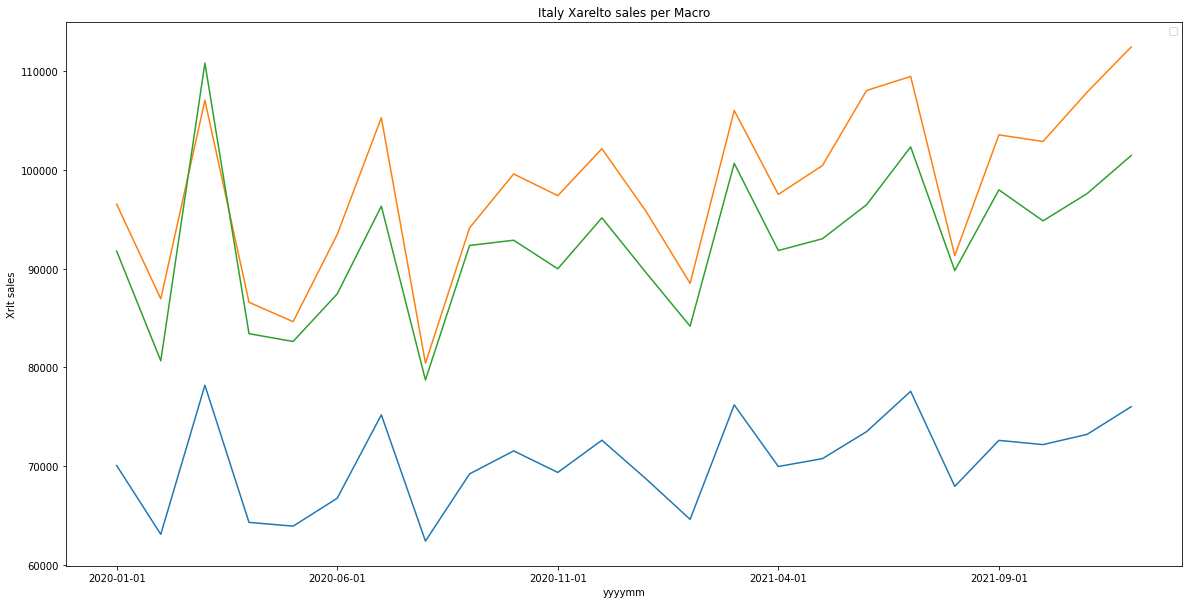

In [25]:
# plot data:
ax = df.plot(figsize=(20,10))
ax.legend([])
ax.set_title('Italy Xarelto sales per Macro')
ax.set_ylabel('Xrlt sales')
plt.show()

In [26]:
# create train-test data:

train = df.iloc[:-10,:]
test = df.iloc[-10:,:]

model = VAR(train)
results = model.fit(maxlags=2) #maxlags is only parameter in that algo!

lag_order = results.k_ar
fcst = results.forecast(train.values[-lag_order:], 10)

model_acc = mape(test, fcst)
print(model_acc)

0.07421441652414681


/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 05, Jul, 2022
Time:                     08:24:19
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    48.9887
Nobs:                     12.0000    HQIC:                   47.8259
Log likelihood:          -318.922    FPE:                1.33751e+21
AIC:                      48.1401    Det(Omega_mle):     3.36961e+20
--------------------------------------------------------------------
Results for equation Macro Centro
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const              111046.806717     59803.028582            1.857           0.063
L1.Macro Centro        -3.673201         1.727766           -2.126           0.034
L1.Macro Nord           1.552406         0.62

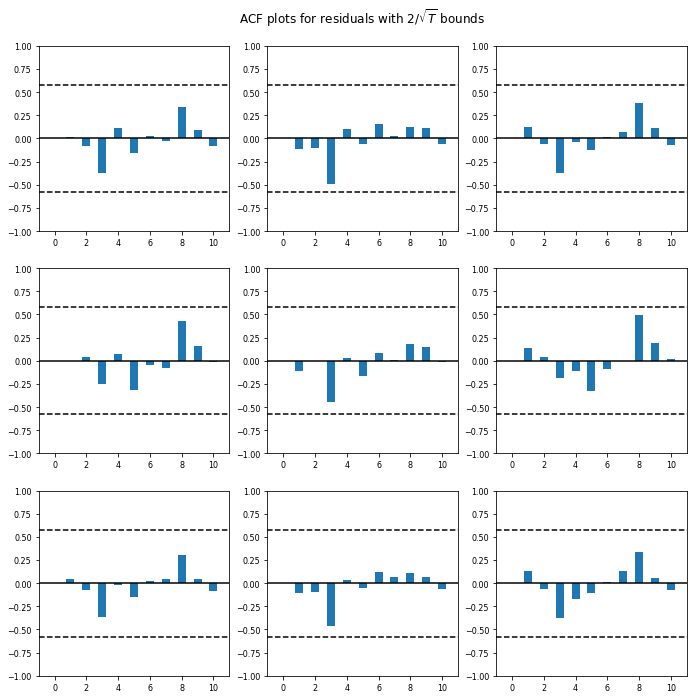

In [28]:
results.plot_acorr()
plt.show()

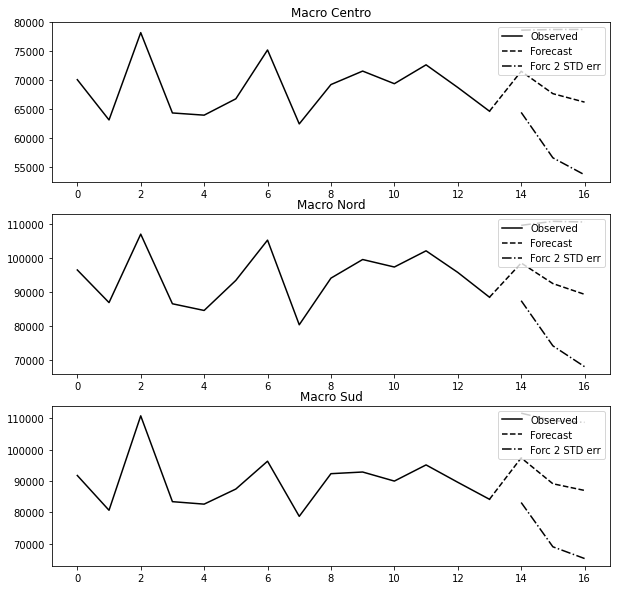

In [29]:
results.plot_forecast(3)
plt.show()

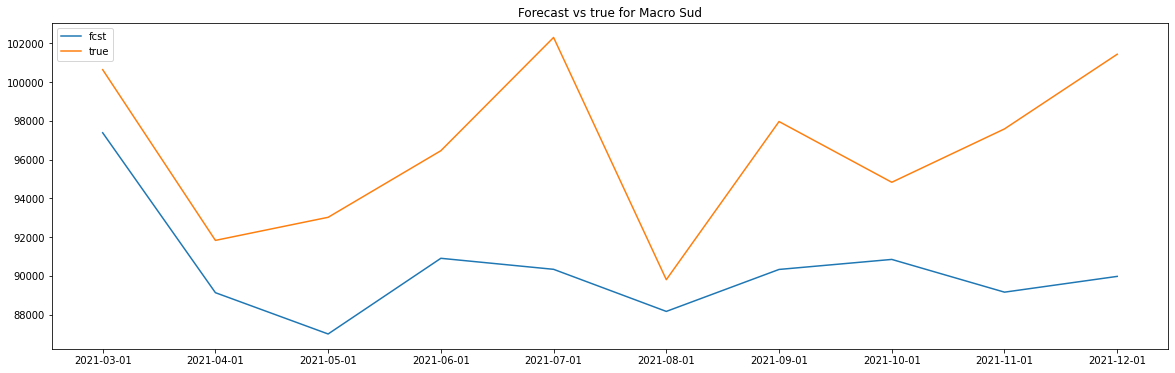

In [30]:
plt.figure(figsize=(20,6))

plt.plot(fcst[:,2], label='fcst')
plt.plot(test.iloc[:,2], label='true')
plt.title('Forecast vs true for Macro Sud')
plt.legend()

In [31]:
# VARMAX:

df = df_asl.pivot_table(index='yyyymm',
                    columns='macro',
                    values='xrlt_sales')
df_asl['visits'] = df_asl.num_cph_visit * df_asl.num_hcp_asl_mccp
exog = df_asl.groupby('yyyymm')['visits'].sum()

train = df.iloc[:-10,:]
test = df.iloc[-10:,:]

exog_train = exog[:-10]
exog_test = exog[-10:]

mod = VARMAX(train, 
             order=(1,1), 
             exog=exog_train)
res = mod.fit(maxiter=100, disp=False)

fcst = res.forecast(exog=exog_test, steps=len(exog_test))
print(mape(test, fcst))

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, s

0.04617413245110203


/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


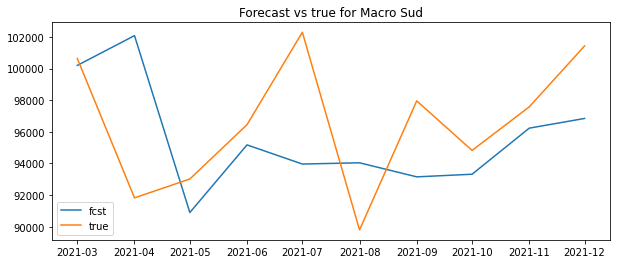

In [32]:
plt.figure(figsize=(10,4))

plt.plot(fcst.index,
         fcst.iloc[:,2], label='fcst')
plt.plot(fcst.index,
         test.iloc[:,2], label='true')
plt.title('Forecast vs true for Macro Sud')
plt.legend()

0.07777212407558444


/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-not

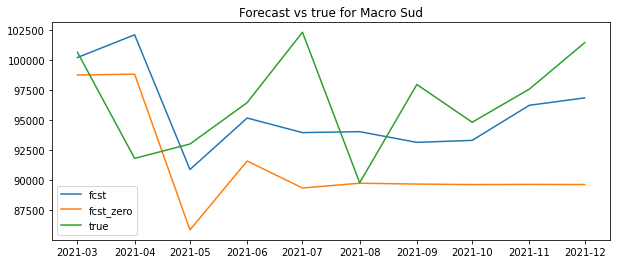

In [33]:
# scale visits to zero:

exog_test = exog_test*0
fcst_zero = res.forecast(exog=exog_test, steps=len(exog_test))
print(mape(test, fcst_zero))

plt.figure(figsize=(10,4))

plt.plot(fcst.index,
         fcst.iloc[:,2], label='fcst')
plt.plot(fcst.index,
         fcst_zero.iloc[:,2], label='fcst_zero')
plt.plot(fcst.index,
         test.iloc[:,2], label='true')
plt.title('Forecast vs true for Macro Sud')
plt.legend()

In [34]:
# estimate treatment effect:

np.sum(fcst.iloc[:,2]) / np.sum(fcst_zero.iloc[:,2]) - 1

0.047204008588277446

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


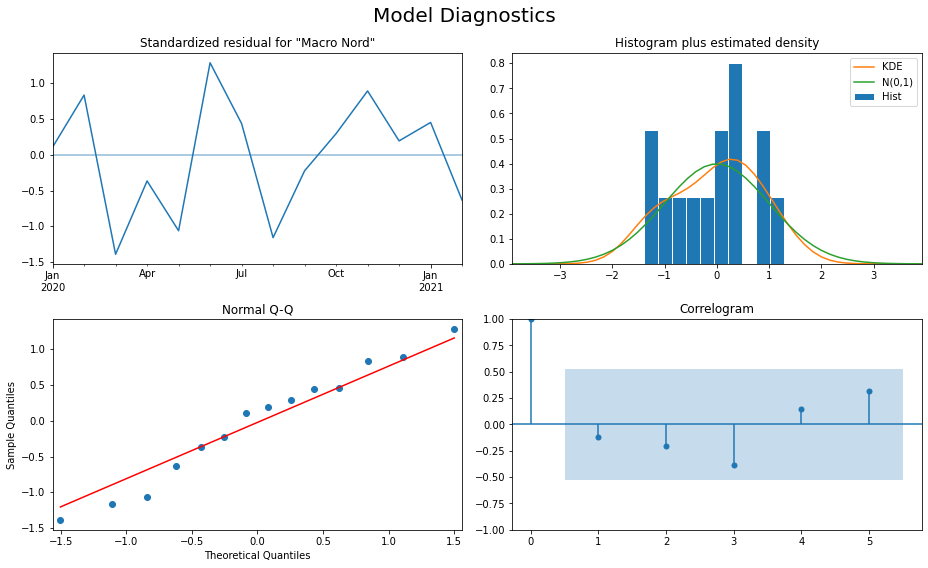

In [35]:
res.plot_diagnostics(variable=1, figsize=(13,8), lags=5)
plt.gcf().suptitle('Model Diagnostics', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=.9);

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


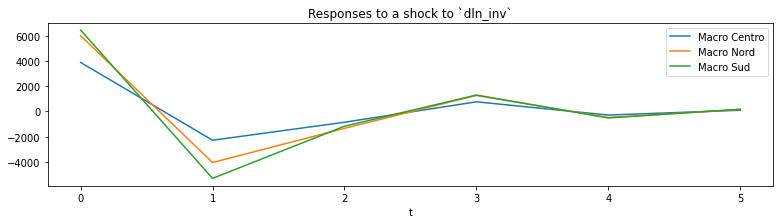

In [36]:
ax = res.impulse_responses(5, 
                           orthogonalized=True, 
                           #impulse=[3,]
                          ).plot(figsize=(13,3))
ax.set(xlabel='t', title='Responses to a shock to `dln_inv`');

### Supervised Machine Learning for time-series

In this section we will apply supervised machine learning techniques for time-series analysis. We will show examples using OLS and Random Forest, but one could apply any other regression method (XG Boost, Knn regression, etc...).

Compared to a classical Arima approach, we need to create features and define a feature set so the regression algorithm can pick up information to understand some pattern in the time-series. People would normally create things like:
- Year
- Month
- Week
- Weekday
- Shifted target values

We will show how to apply differencing the target and how to un-difference again to obtain level data again for better comparison (because normally we want to understand how well we can explain our level data and not our differenced data).

Furthermore we will show one-step ahead forecasting and multistep forecasting.
Normally a regression method only allows us to do a one-step ahead forecast (as we have a set of features explaining one target value for each observation i per time point). But we can also benefit from the multioutput regression technique, which allows us to do multistep forecasting. Ins scikit-learn many algorithms have the inbuild possibility to do multioutput regression, but one could also apply a multioutput wrapper and apply this to any other algorithm.

For multioutput forecasting one needs to create a specific vector shape, which maps a set of cavariate features to a list of n target values, which allows us to make n forecasting steps into the future.

In [37]:
from sklearn.ensemble import RandomForestRegressor

In [38]:
df = sm.datasets.co2.load_pandas()
df = df.data

#df= df.resample('M').mean().ffill()
df = df.dropna()

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [39]:
# create month and year from index

df['month'] = [x.month for x in df.index]
df['year'] = [x.year for x in df.index]
df['week'] = [x.week for x in df.index]

In [40]:
# create differenced co2 data:
df['co2_diff'] = df.co2.diff()

In [41]:
# created shifted values:

df['co2_shift1'] = df.co2.shift(1)
df['co2_shift2'] = df.co2.shift(2)
df['co2_shift3'] = df.co2.shift(3)
df['co2_shift4'] = df.co2.shift(4)
df['co2_shift5'] = df.co2.shift(5)
df['co2_shift6'] = df.co2.shift(6)
################
df['co2_diff_shift1'] = df.co2_diff.shift(1)
df['co2_diff_shift2'] = df.co2_diff.shift(2)
df['co2_diff_shift3'] = df.co2_diff.shift(3)
df['co2_diff_shift4'] = df.co2_diff.shift(4)
df['co2_diff_shift5'] = df.co2_diff.shift(5)
df['co2_diff_shift6'] = df.co2_diff.shift(6)

In [42]:
# create target and feature list + add constant!

df = df.dropna().copy()

X = df[['year', 'month', 'week',
        'co2_shift1',
       'co2_shift2', 'co2_shift3',
       'co2_shift4', 'co2_shift5',
       'co2_shift6']]
X = sm.add_constant(X)

y = df['co2']

In [43]:
# Fitting OLS with month and year

model = sm.OLS(y,X)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    co2   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.572e+05
Date:                Tue, 05 Jul 2022   Prob (F-statistic):               0.00
Time:                        08:24:24   Log-Likelihood:                -1350.2
No. Observations:                2218   AIC:                             2720.
Df Residuals:                    2208   BIC:                             2777.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -102.7365      9.331    -11.011      0.000    -121.034     -84.439
year           0.0595      0.005     11.034      0.000       0.049       0.070
month          0.0014      0.010      0.134      0.894      -0.019       0.022
week          -0.0005      0.002     -0.193      0.847      -0.005       0.004
co2_shift1     0.8939      0.021     42.784      0.000       0.853       0.935
co2_shift2     0.1384      0.028      4.901      0.000       0.083       0.194
co2_shift3     0.2136      0.028      7.538      0.000       0.158       0.269
co2_shift4    -0.0724      0.028     -2.558      0.011      -0.128      -0.017
co2_shift5    -0.0271      0.028     -0.961      0.337      -0.082       0.028
co2_shift6    -0.1905      0.021     -9.100      0.000      -0.232      -0.149
==============================================================================
Omnibus:                       47.963   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.833
Skew:                          -0.013   Prob(JB):                     4.68e-23
Kurtosis:                       4.055   Cond. No.                     2.12e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


0.0007877057314279458
0.2908732436995744


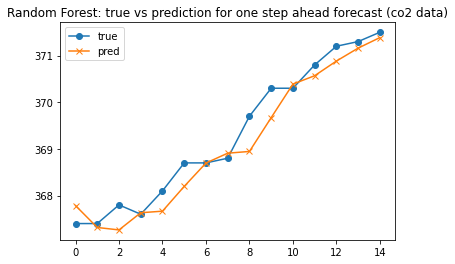

In [44]:
# build one-step ahead forecast:
df = df.dropna().copy()

X = df[['year', 'month','week', 'co2_shift1',
       'co2_shift2', 'co2_shift3',
       'co2_shift4', 
        #'co2_shift5',
       #'co2_shift6'
       ]]

y = df['co2']

###############
start_test = df.index.max() -  pd.DateOffset(n=100)
date_ranges = df[df.index >= start_test].index

preds = []
test_values = []

ols = 1

for i in date_ranges:
    X_train = X[X.index<i].copy()
    y_train = y[y.index<i].copy()
    
    X_test = X[X.index==i].copy()
    y_test = y[y.index==i].copy()
    
    if ols == 1:
        X_train = sm.add_constant(X_train, has_constant='add')
        X_test = sm.add_constant(X_test, has_constant='add')
        model = sm.OLS(y_train, X_train)
        res = model.fit()
    else:
        model = RandomForestRegressor()
        res = model.fit(X_train, y_train)
    
    preds.append(res.predict(X_test))
    test_values.append(y_test)
    
print(mape(test_values, preds))
print(mae(test_values, preds))

# plot true vs predictions:

plt.plot(test_values, marker='o', label='true')
plt.plot(preds, marker='x', label='pred')
plt.title('Random Forest: true vs prediction for one step ahead forecast (co2 data)')
plt.legend()

##### Onestep ahead: train on differenced target

In [45]:
df = df.dropna().copy()

X = df[['year', 'month','week', 'co2_diff_shift1',
       'co2_diff_shift2', 'co2_diff_shift3',
       'co2_diff_shift4', 
        'co2_diff_shift5',
       'co2_diff_shift6'
       ]]
X = sm.add_constant(X)
y = df['co2_diff']

model = sm.OLS(y,X)
res = model.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               co2_diff   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     50.37
Date:                Tue, 05 Jul 2022   Prob (F-statistic):           2.36e-83
Time:                        08:24:25   Log-Likelihood:                -1409.7
No. Observations:                2218   AIC:                             2839.
Df Residuals:                    2208   BIC:                             2896.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4797      1.547     -0.310      0.757      -3.514       2.555
year                0.0002      0.001      0.277      0.782      -0.001       0.002
month               0.0005      0.011      0.044      0.965      -0.020       0.021
week                0.0021      0.002      0.871      0.384      -0.003       0.007
co2_diff_shift1    -0.0615      0.021     -2.894      0.004      -0.103      -0.020
co2_diff_shift2     0.0726      0.021      3.452      0.001       0.031       0.114
co2_diff_shift3     0.2725      0.021     13.162      0.000       0.232       0.313
co2_diff_shift4     0.1921      0.021      9.179      0.000       0.151       0.233
co2_diff_shift5     0.1633      0.021      7.622      0.000       0.121       0.205
co2_diff_shift6     0.0268      0.022      1.237      0.216      -0.016       0.069
==============================================================================
Omnibus:                       42.900   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               85.799
Skew:                          -0.050   Prob(JB):                     2.34e-19
Kurtosis:                       3.958   Cond. No.                     3.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


0.004681850224520557


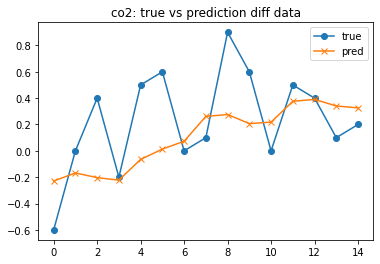

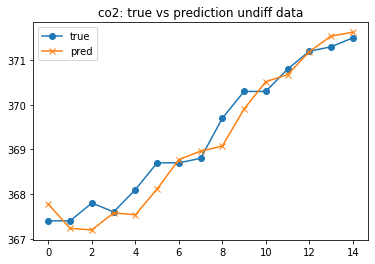

In [46]:
# build one-step ahead forecast:
df = df.dropna().copy()

X = df[['year', 'month','week', 'co2_diff_shift1',
       'co2_diff_shift2', 'co2_diff_shift3',
       'co2_diff_shift4', 
        'co2_diff_shift5',
       #'co2_shift6'
       ]]

y = df['co2_diff']

######################
start_test = df.index.max() -  pd.DateOffset(n=100)
date_ranges = df[df.index >= start_test].index

preds_diff = []
preds_undiff = []
test_values_diff = []
test_values_undiff = []

ols = 1

for i in date_ranges:
    X_train = X[X.index<i].copy()
    y_train = y[y.index<i].copy()
    
    X_test = X[X.index==i].copy()
    y_test = y[y.index==i].copy()
    
    if ols == 1:
        X_train = sm.add_constant(X_train, has_constant='add')
        X_test = sm.add_constant(X_test, has_constant='add')
        model = sm.OLS(y_train, X_train)
        res = model.fit()
    else:
        model = RandomForestRegressor()
        res = model.fit(X_train, y_train)
        
    preds_diff.append(res.predict(X_test))
    preds_undiff.append(res.predict(X_test) + df[df.index==i].co2_shift1.values)
    test_values_diff.append(y_test)
    test_values_undiff.append(df[df.index==i].co2.values[0])
    
#print(mape(test_values_diff, preds_diff))
print(mape(test_values_undiff, preds_undiff))

# plot true vs predictions:

plt.plot(test_values_diff, marker='o', label='true')
plt.plot(preds_diff, marker='x', label='pred')
plt.title('co2: true vs prediction diff data')
plt.legend()
plt.show()

###############

plt.plot(test_values_undiff, marker='o', label='true')
plt.plot(preds_undiff, marker='x', label='pred')
plt.title('co2: true vs prediction undiff data')
plt.legend()
plt.show()

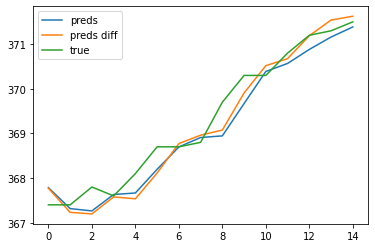

In [47]:
# compare forecasts with level data vs training on differenced data: 

plt.plot(preds, label='preds')
plt.plot(preds_undiff, label='preds diff')
plt.plot(test_values, label='true')
plt.legend()

##### Multistep forecasting

In [48]:
from sklearn.linear_model import LinearRegression
from typing import Any, Dict, Iterable, List, Mapping, Optional, Tuple

In [49]:
def multistep_pre_process(y: pd.Series, 
                          X: pd.Series, 
                          steps: List[int]) -> np.array:
    '''
    Creates an array with length = steps
    to allow multistep forecasting.
    Steps defines the number of forecasting
    steps into the future.
    '''
    y_trans = []
    steps = steps
    a = np.arange(1, steps+1, 1)

    for i,v in enumerate(y):
        try:
            y_trans.append(y[i:i+len(a)])
        except IndexError:
            pass
        continue
    y_trans = list(filter(lambda elmnts: len(elmnts)>steps-1, y_trans))
    
    max_date = y_trans[-1].index.min()
    X = X[(X.index<=max_date)].copy()
    return np.array(y_trans), X.values

In [50]:
# Built multistep fc loop:

df = df.dropna().copy()

X = df[['year', 'month','week', 'co2_shift1',
       'co2_shift2', 'co2_shift3',
       'co2_shift4', 
        'co2_shift5',
       'co2_shift6'
       ]]

y = df['co2']

fc_steps = 10
y_multi, X_multi = multistep_pre_process(y, X, fc_steps)

start_test = len(y_multi) - (fc_steps*2)
date_ranges = np.arange(start_test, len(y_multi), 1)

ols = 1

preds_multi = []
test_values_multi = []

for i in date_ranges:
    if i+fc_steps < len(X_multi):
        X_train = X_multi[:i].copy()
        y_train = y_multi[:i].copy()

        X_test = X_multi[i+fc_steps]
        y_test = y_multi[i+fc_steps]

        if ols == 1:
            model = LinearRegression()
            res = model.fit(X_train, y_train)
        else:
            model = RandomForestRegressor()
            res = model.fit(X_train, y_train)

        pred_temp = res.predict([X_test])[0]
        preds_multi.append(pred_temp)
        test_values_multi.append(y_test)

print(mae(np.concatenate(test_values_multi),
          np.concatenate(preds_multi)))
print(mape(np.concatenate(test_values_multi),
          np.concatenate(preds_multi)))

1.4413202492153083
0.003900107983267354


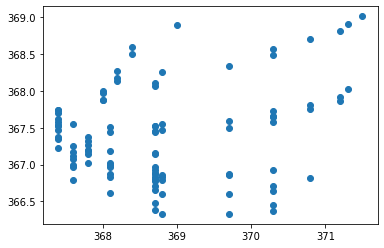

In [51]:
# scatterplot between true and multistep prediction

plt.scatter(np.concatenate(test_values_multi),
          np.concatenate(preds_multi))

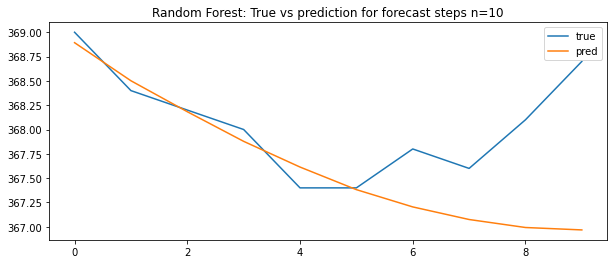

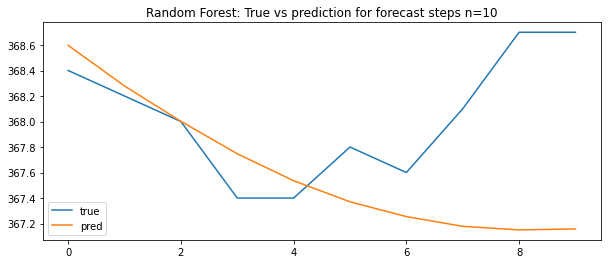

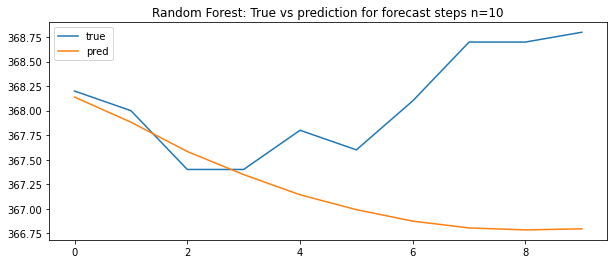

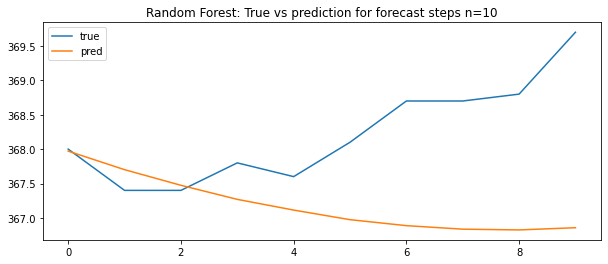

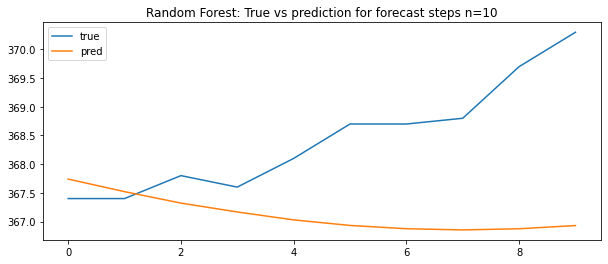

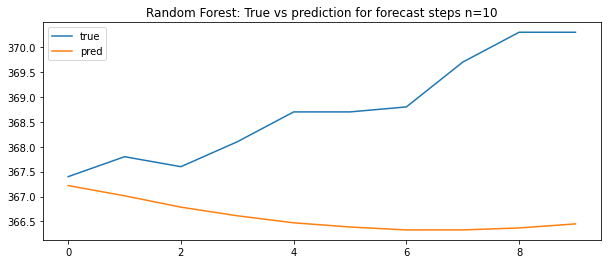

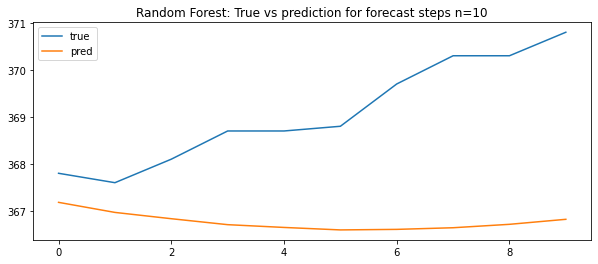

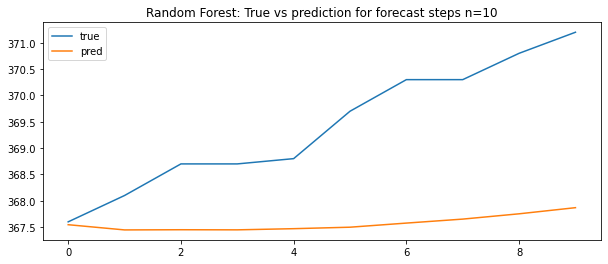

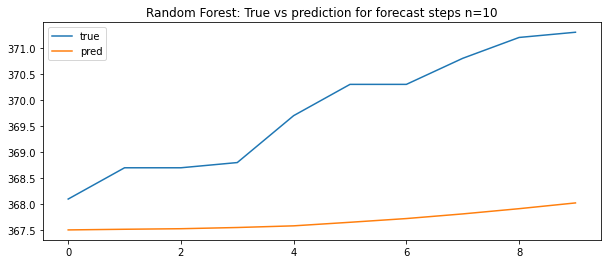

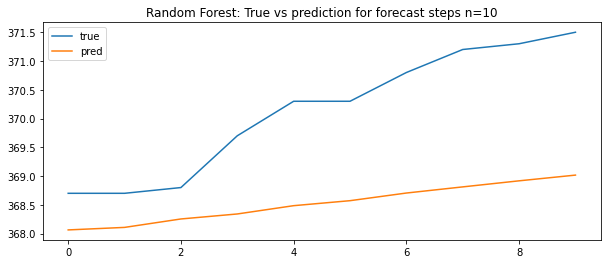

In [52]:
for i,v in enumerate(preds_multi):
    plt.figure(figsize=(10,4))
    plt.plot(test_values_multi[i], label='true')
    plt.plot(preds_multi[i], label='pred')
    plt.legend()
    plt.title('Random Forest: True vs prediction for forecast steps n={}'.format(fc_steps))
    plt.show()

### LSTM with Keras

Here we show a simple LSTM using Keras. Potential parameters to optimize would be:
- number of layers
- number of nodes in each layer
- optimzer
- learning rate
- batch size
- number of epochs

In [53]:
import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM

from sklearn.preprocessing import MinMaxScaler

import random

2022-07-05 08:24:27.999798: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-05 08:24:27.999832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [88]:
df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv')

df_asl = df_asl[(df_asl.asl!='FABRIANO')
               #&(df_asl.region!='VALLE D\'AOSTA')
               # &(df_asl.region!='MARCHE')
               ].copy()
df_asl['visits'] = df_asl.num_cph_visit * df_asl.num_hcp_asl_mccp
df = df_asl.groupby('yyyymm')['xrlt_sales'].sum().reset_index()

In [89]:
# pre-processing:

n_future = 3
n_past = 5*n_future
total_period = 18

y_scaler = MinMaxScaler()
y = list(df.xrlt_sales)[:-n_future]
y = np.concatenate(y_scaler.fit_transform(np.array(y).reshape(-1, 1))).tolist()

y_test = list(df.xrlt_sales)[-n_future:]
y_test = np.concatenate(y_scaler.transform(np.array(y_test).reshape(-1, 1))).tolist()

idx_end = len(y)
idx_start = idx_end - total_period

x_new = []
y_new = []

while idx_start>0:
    x_line = y[idx_start:idx_start+n_past]
    y_line = y[idx_start+n_past:idx_start+total_period]
    x_new.append(x_line)
    y_new.append(y_line)
    idx_start-=1
    
x_new = np.array(x_new)
y_new = np.array(y_new)

In [90]:
# define architecture of the lstm:

n_samples = x_new.shape[0]
n_timesteps = x_new.shape[1]
n_steps = y_new.shape[1]
n_covariates = 1

random.seed(42)

x_new = x_new.reshape(n_samples, n_timesteps, n_covariates)
#x_new = x_new.reshape(n_samples, n_timesteps, n_features)

simple_model = Sequential([LSTM(64,
                               activation='tanh',
                               input_shape=(n_timesteps,
                                            n_covariates),
                               return_sequences=True),
                           LSTM(64, activation='tanh', return_sequences=True),
                           LSTM(64, activation='tanh'),
                           Dense(y_new.shape[1])
                          ])

simple_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 15, 64)            16896     
                                                                 
 lstm_12 (LSTM)              (None, 15, 64)            33024     
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 83,139
Trainable params: 83,139
Non-trainable params: 0
_________________________________________________________________


In [91]:
# define optimzer:

simple_model.compile(optimizer=keras.optimizers.Adam(learning_rate=.001),
                    loss='mean_squared_error',
                    metrics=['mean_squared_error'],
                    )

In [95]:
# train model: 

batch_size = 32

smod_history = simple_model.fit(x_new, 
                                y_new,
                                validation_split=.2,
                                epochs=15,
                                batch_size=batch_size,
                                shuffle=True
                               )

Epoch 1/15
1/1 [==============================] - 0s 67ms/step - loss: 0.2841 - mean_squared_error: 0.2841 - val_loss: 0.2576 - val_mean_squared_error: 0.2576
Epoch 2/15
1/1 [==============================] - 0s 38ms/step - loss: 0.2172 - mean_squared_error: 0.2172 - val_loss: 0.1750 - val_mean_squared_error: 0.1750
Epoch 3/15
1/1 [==============================] - 0s 34ms/step - loss: 0.1483 - mean_squared_error: 0.1483 - val_loss: 0.0959 - val_mean_squared_error: 0.0959
Epoch 4/15
1/1 [==============================] - 0s 34ms/step - loss: 0.0870 - mean_squared_error: 0.0870 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 5/15
1/1 [==============================] - 0s 35ms/step - loss: 0.0541 - mean_squared_error: 0.0541 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 6/15
1/1 [==============================] - 0s 34ms/step - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.0849 - val_mean_squared_error: 0.0849
Epoch 7/15
1/1 [==============================

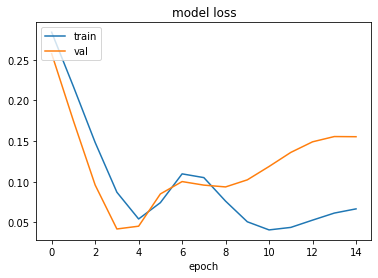

In [96]:
plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 0s 18ms/step


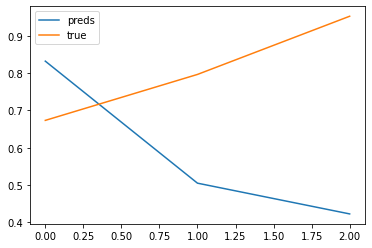

In [97]:
preds = simple_model.predict(np.array(y[-n_past:]).reshape(1,15))

plt.plot(preds[0], label='preds')
plt.plot(y_test, label='true')
plt.legend()
plt.show()

### DeepAR

In [76]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
import mxnet as mx
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.util import to_pandas
from itertools import islice

In [15]:
df_asl = pd.read_csv('s3://phmsbi-cpd-analytics-dev/jan_rathfelder/ita/xrlt/impact_attribution.predictive_modeling/model_input_asl_new.csv')

df_asl = df_asl[(df_asl.asl!='FABRIANO')
               #&(df_asl.region!='VALLE D\'AOSTA')
               # &(df_asl.region!='MARCHE')
               ].copy()
df_asl['visits'] = df_asl.num_cph_visit * df_asl.num_hcp_asl_mccp
df = df_asl.groupby('yyyymm')[['xrlt_sales', 'visits']].sum().reset_index()
df['yyyymm'] = pd.to_datetime(df.yyyymm)
df = df.set_index('yyyymm')

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):


In [16]:
prediction_length = 3
train_time = max(df.index)-pd.DateOffset(months=3)

In [17]:
y_scaler = MinMaxScaler()

a = np.concatenate(y_scaler.fit_transform(np.array(df[df.index<=train_time].xrlt_sales).reshape(-1, 1))).tolist()
b = np.concatenate(y_scaler.transform(np.array(df[df.index>train_time].xrlt_sales).reshape(-1, 1))).tolist()

df['xrlt_sales'] = a+b
###################
y_x = MinMaxScaler()

c = np.concatenate(y_scaler.fit_transform(np.array(df[df.index<=train_time].visits).reshape(-1, 1))).tolist()
d = np.concatenate(y_scaler.transform(np.array(df[df.index>train_time].visits).reshape(-1, 1))).tolist()

df['visits'] = c+d

In [18]:
df.corr()

,xrlt_sales,visits
xrlt_sales,1.000000,0.601437
visits,0.601437,1.000000


(array([[0.50854979, 0.13315578, 1.        , 0.17532542, 0.13031974,
         0.36343027, 0.77407846, 0.        , 0.46371087, 0.59147089,
         0.49251708, 0.67219546, 0.45352955, 0.21815864, 0.84657368,
         0.52327003, 0.59410319, 0.79195222, 0.93951806, 0.37331609,
         0.72345968, 0.67346607, 0.79681767, 0.95297954]]),
 array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.05157084, 0.25643154, 0.15281565, 0.26141079, 0.52625963,
         0.20047421, 0.39857736, 0.16324837, 0.57759336, 1.        ,
         0.45880261, 0.41671606, 0.69081209, 0.65619443, 0.0243035 ,
         0.67575578, 0.96075874, 1.0114997 , 0.92649674]]))

In [37]:
# Use this for training without features!!!

# define target and features

target = np.array([df['xrlt_sales']])
#feat_static_real = np.array([df['visits']])
data_gluton = (target)

# train dataset: cut the last window of length "prediction_length", 
# add "target" and "start" fields

freq='M'
start = df.index[0]

train_ds = ListDataset(
    [{'target': x, 'start': start} for x in target[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in target],
    freq=freq
)

In [86]:
data_gluton[0].shape[0]

1

In [78]:
# Use this if you want to add features!!
target = np.array([df['xrlt_sales']])
feat_dynamic_real = np.array([df['visits']])
data_gluton = (target, feat_static_real)

# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': data_gluton[0].shape[0], # number of target series
    'num_steps': 12*2, #would be called freq in other models: 12=monthly data, etc
    'prediction_length': prediction_length,
    'freq': 'M',
    'start': [
        pd.Timestamp(df.index[0], freq='M')
        for _ in range(df.shape[0])
    ]
}

# Here we define a dynamic_real value on top of the target
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']]
            #feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

print(test_entry.keys(), train_entry.keys())
test_entry

dict_keys(['target', 'start', 'feat_dynamic_real']) dict_keys(['target', 'start', 'feat_dynamic_real'])


{'target': array([0.5085498 , 0.13315578, 1.        , 0.17532542, 0.13031974,
        0.36343026, 0.7740785 , 0.        , 0.46371087, 0.5914709 ,
        0.49251708, 0.67219543, 0.45352957, 0.21815863, 0.8465737 ,
        0.52327   , 0.5941032 , 0.7919522 , 0.93951803, 0.37331608,
        0.72345966, 0.6734661 , 0.79681766, 0.95297956], dtype=float32),
 'start': Period('2020-01', 'M'),
 'feat_dynamic_real': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.05157084, 0.25643155, 0.15281565, 0.2614108 , 0.52625966,
         0.20047422, 0.39857736, 0.16324838, 0.5775934 , 1.        ,
         0.4588026 , 0.41671607, 0.6908121 , 0.65619445, 0.0243035 ,
         0.6757558 , 0.96075875, 1.0114998 , 0.92649674]], dtype=float32)}

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/compat.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  op(LooseVersion(mpl.__version__), LooseVersion(version))
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: DeprecationWarning: `np.bool` is a depr

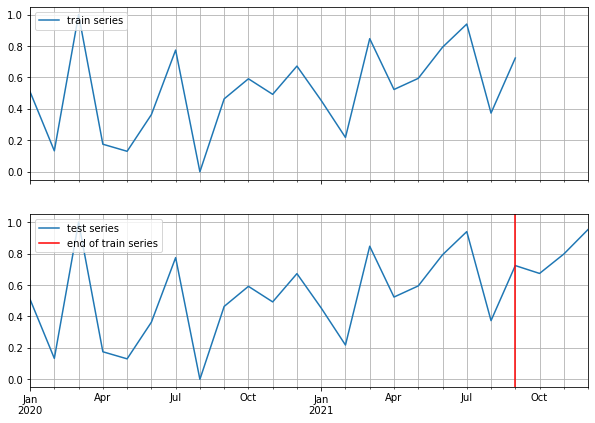

In [79]:
train_entry = next(iter(train_ds))
train_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()
#################

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [80]:
np.random.seed(7)
mx.random.seed(7)

estimator = DeepAREstimator(
            prediction_length=prediction_length,
            context_length=prediction_length*5,
            freq='M', #custom_ds_metadata['freq']
            trainer=Trainer(
            epochs=5,
            learning_rate=.01,  #1e-3,
            num_batches_per_epoch=100)
)

/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:159: DeprecationWarning: Trainer argument "learning_rate_decay_factor" is deprecated. Use callbacks instead.
  DeprecationWarning,
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:169: DeprecationWarning: Trainer argument "patience" is deprecated. Use callbacks instead.
  DeprecationWarning,
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/gluonts/mx/trainer/_base.py:176: DeprecationWarning: Trainer argument "minimum_learning_rate" is deprecated. Use callbacks instead.
  DeprecationWarning,


In [81]:
predictor = estimator.train(train_ds)

100%|██████████| 100/100 [00:03<00:00, 28.09it/s, epoch=5/5, avg_epoch_loss=-2.86]


/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  elif issubclass(data.dtype.type, np.bool) or is_bool_dtype(data):
/home/jan_rathfelder/Development/scale-up-codebase/env_2/lib/python3.7/site-packages/pandas/core/indexes/base.py:395: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

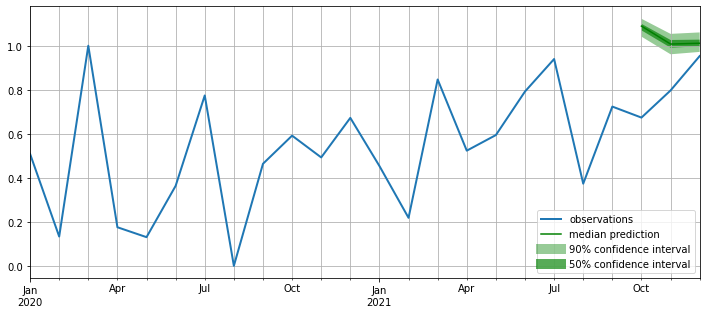

In [82]:
# Compare forecast vs true

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_ds, 
                                                 predictor=predictor, 
                                                 num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=len(df), num_plots=1)